In [1]:
import base64
import pathlib

import torch
import torch.utils.data as data
import torch.nn as nn
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Why

What are you looking at now? Typically in the year 2023, you'd be looking at an a computer display that has about 2 million to 8 million pixels, with 3 color channels each. In the multilayer perceptrons (MLPs) that we've looked at before, taking one of these images as input would require, for example, 3 * 3840 * 2160 = 24883200 parameters in the first layer. This would work, but it's mostly a waste of parameters due to certain properties of natural images.

Consider this image in the context of identifying the primary object in the image. 
<div>
<img src="data/cat.jpg" width="200"/>
</div>

([Source](https://commons.wikimedia.org/wiki/File:Orange_tabby_cat_sitting_on_fallen_leaves-Hisashi-01A.jpg))

For that task, this image contains a lot if unnecessary and redundant information. For example, while most of the image is of leaves on the ground, most humans would say that this image is of a cat. Also, we don't really need much information about color or texture to do that. Let's do some image processing to reduce unnecessary information and see whether we can still say it's a cat.

As I obtained this image as a JPEG file, we can use the file size as a rough proxy for the amount of information in the image. As is, the image size in bytes is

In [3]:
pathlib.Path("data/cat.jpg").stat().st_size

3586298

First, let's change the image to grayscale.

In [4]:
image = torchvision.io.read_image("data/cat.jpg")
grayscaled_image = image.type(torch.float32).mean(0, keepdim=True).type(torch.uint8)

In [5]:
def show_images(images: tuple[torch.Tensor, ...] | torch.Tensor):
    if not isinstance(images, tuple):
        images = (images,)
    _, axs = plt.subplots(ncols=len(images), squeeze=False)
    for i, image in enumerate(images):
        image = image.detach()
        if image.shape[0] == 3:
            axs[0, i].imshow(image.permute(1, 2, 0).numpy())
        else:
            axs[0, i].imshow(image[0].numpy(), cmap="gray")
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

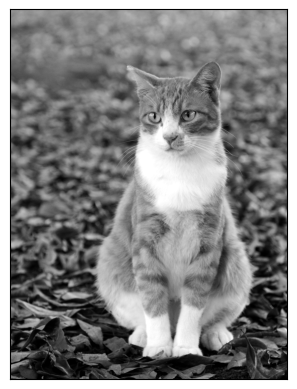

In [6]:
show_images(grayscaled_image)

Let's check how big this would be if saved in JPEG.

In [7]:
temp_folder = pathlib.Path("temp")
temp_folder.mkdir(exist_ok=True)

torchvision.io.write_jpeg(grayscaled_image, str(temp_folder / "cat_grayscale.jpg"), quality=90)
(temp_folder / "cat_grayscale.jpg").stat().st_size

956090

Using pretty high quality settings, it's already much smaller.

Another thing we could do is lower the number of pixels.

In [8]:
grayscaled_image.shape

torch.Size([1, 2848, 2136])

Since this resolution is unnecessarily high for the task, we'll downsample it to a quarter the resolution by keeping every fourth pixel.

In [9]:
downsampled_image = grayscaled_image[:, ::4, ::4]
downsampled_image.shape

torch.Size([1, 712, 534])

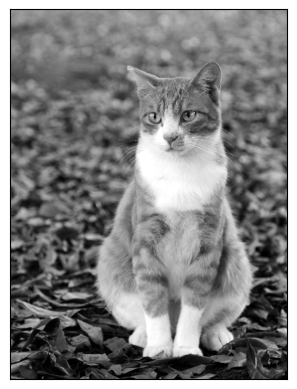

In [10]:
show_images(downsampled_image)

Still looks like a cat to me.

Another thing we could do is just keep some edges, say the vertical edges. We can do that by applying a filter to the image using cross-correlation.

# Cross-correlation

A convolutional layer, despite its name, is often a **cross-correlation**, followed by an addition.

The cross-correlation of vectors $\mathbf{w}$ and $\mathbf{x}$ is $\mathbf{w} \star \mathbf{x} = \mathbf{z} \in \mathbb{R}^{|\mathbf{x}|-|\mathbf{w}|+1}$ whose each element
$\mathbf{z}_i = \sum_{j=1}^{|\mathbf{w}|} \mathbf{w}_{j} \mathbf{x}_{i+j-1}$.

For example, suppose $\mathbf{w} = \begin{bmatrix}1 \\ 2 \\ 3 \end{bmatrix}$ and $\mathbf{x} = \begin{bmatrix}1 \\ 2 \\ 3 \\ 4 \\ 5 \end{bmatrix}$. Then $\mathbf{w} \star \mathbf{x} = \begin{bmatrix}1*1 + 2*2 + 3*3 \\ 1*2 + 2*3 + 3*4 \\ 1*3 + 2*4 + 3*5 \end{bmatrix} = \begin{bmatrix} 14 \\ 20 \\ 26 \end{bmatrix}$.

MATRIX MULTIPLICATION AND DOT PRODUCT: Matrix multiplication is basically a matrix version of the dot product. Remember the result of dot product is a scalar. The result of matrix multiplication is a matrix, whose elements are the dot products of pairs of vectors in each matrix

If you reverse either one of $\mathbf{w}$ or $\mathbf{x}$, you'll get mathematical convolution.
> When machine learning people say "convolution," they usually mean cross-correlation.

We often refer to $\mathbf{w}$ as the *kernel*, or the *filter*. Some people use *filter* to refer to a set of multiple kernels in the same layer.

Let's see whether you follow. Complete the following function.

In [16]:
def conv1d(x: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
    """
    :returns: the 1-dimensional cross-correlation of w and x
    """
    z = torch.empty(x.shape[0] - w.shape[0] + 1)
    for i in range(z.shape[0]):
        z[i] = (x[i:i+w.shape[0]] @ w).sum() # or w @ x[i : i + w.shape[0]]
    return z

In [17]:
w = torch.tensor((1, 2, 3))
x = torch.tensor((1, 2, 3, 4, 5))
torch.equal(conv1d(x, w), torch.tensor([14, 20, 26]))

True

Uncomment the following cell to see a solution.

In [13]:
print(base64.b64decode(b'eltpXSA9IHcgQCB4W2kgOiBpICsgdy5zaGFwZVswXV0=').decode())

z[i] = w @ x[i : i + w.shape[0]]


To apply my vertical edge filter, I'll make a kernel like this

$\mathbf{W} = \begin{bmatrix} -1 & 0 & 1 \\
                              -1 & 0 & 1 \\
                              -1 & 0 & 1 \end{bmatrix}$

and perform a 2-dimensional convolution over the image. You can probably guess how that works.

In [19]:
def conv2d(x: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
    """
    :returns: the 2-dimensional cross-correlation of w and x
    """
    z = torch.empty(tuple(torch.tensor(x.shape) - torch.tensor(w.shape) + 1))
    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            z[i, j] = (w * x[i : i + w.shape[0], j : j + w.shape[1]]).sum()
    return z

In [20]:
x = torch.randn(4, 4)
w = torch.randn(2, 2)
torch.allclose(torch.nn.functional.conv2d(x[None, :], w[None, None, :])[0], conv2d(x, w))

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


True

In [18]:
print(base64.b64decode(b'eltpLCBqXSA9ICh3ICogeFtpIDogaSArIHcuc2hhcGVbMF0sIGogOiBqICsgdy5zaGFwZVsxXV0pLnN1bSgp').decode())

z[i, j] = (w * x[i : i + w.shape[0], j : j + w.shape[1]]).sum()


You might be thinking that this is very inefficient, and you'd be right. For now, let's just use it and leave the performance tweaking to others.

Back to our cat image. Let's apply this filter and look at the vertical edges detected.

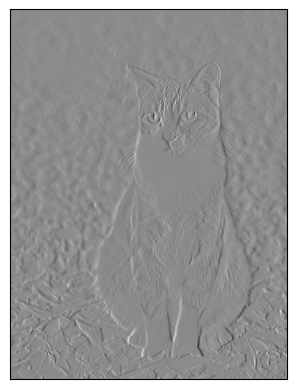

In [24]:
#vertical_edges = conv2d(downsampled_image[0], torch.tensor(((-1, 0, 1),) * 3))[None, :]
vertical_edges = conv2d(downsampled_image[0], torch.tensor(((-1, 0, 1),(-2,0,2),(-1,0,1))))[None, :]
show_images(vertical_edges)

It's harder now, but I can still tell this is a cat. Let's save it as JPEG and check the file size. Since pixel values were summed while applying this filter, we have to rescale the result in order to save it as an image.

In [25]:
vertical_edges_image = vertical_edges
vertical_edges_image -= vertical_edges_image.min()
vertical_edges_image *= 255 / vertical_edges_image.max()
vertical_edges_image = vertical_edges_image.to(torch.uint8)
torchvision.io.write_jpeg(vertical_edges_image, str(temp_folder / "cat_vertical_edges.jpg"), quality=90)
(temp_folder / "cat_vertical_edges.jpg").stat().st_size

66207

When I ran this, I ended up with 65404 bytes, down from the original 3586298, so that's about 1/50 the original size.

To recap,

> We (humans) wanted to perform image classification.

> We observed that not all pixels are equally relevant.

> We tried reducing the amount of irrelevant information in the image by processing it using various methods, one of which was cross-correlation with a kernel created to highlight vertical edges.

> We observed a great reduction in information while still being able to correctly classify the image.

Because we reduced the information so much, we can use multiple kernels to inform our decision. For example, we could use a horizontal edge detector, like this.

$\mathbf{W} = \begin{bmatrix} -1 & -1 & -1 \\
                              0 & 0 & 0 \\
                              1 & 1 & 1 \end{bmatrix}$

Then we'll have both the vertical and horizontal edges to look at.

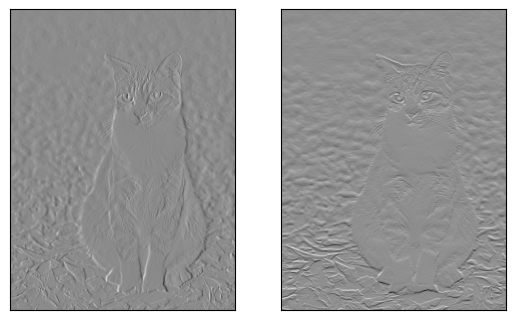

In [26]:
show_images((vertical_edges, 
             conv2d(downsampled_image[0], torch.tensor(((-1, -1, -1), (0, 0, 0), (1, 1, 1))))[None, :]))

Worth discussing with your friends:
> Why is cross-correlation advantageous over simple linear transformations (as in MLPs) in image-related tasks?

# Learning kernels

In this section, you'll benefit from using a GPU if you have one.

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Convolutional neural network layers often have many kernels of different shapes and *strides* (how many pixels to move the kernel over after each $i$ or $j$ step; we've been using a stride of 1 in this notebook). The kernels are learnable, so their elements serve as parameters in the neural network.

Each kernel learns to detect a certain feature in the input. If they work well, they'll distill the relevant information from the input. Earlier layers detect simple features such as edges, while later layers detect more sophisticated things such as shapes or faces.


In classifiers, the combined outputs of the convolutional layers will inform a final linear layer that performs the classification.



Before, we made a kernel that detected vertical edges.

$\begin{bmatrix} -1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 \end{bmatrix}$

Let's try to learn this kernel from a random initialization.

We'll learn $\mathbf{W}$ as parameters of a function $\hat{f}$ that we will train to detect vertical edges, i.e. $\hat{f}$ is just a 2-dimensional cross-correlation.

Instead of using the `conv2d` we wrote before, we'll use the `nn.Conv2d` `Module` in PyTorch. PyTorch `Module`s are functions that keep track of their parameters and gradients. You can compose a bunch of `Module`s together and call a `backward` function at the end, which adds the derivative of the composition with respect to all parameters.

This `nn.Conv2d` constructor makes a 2-dimensional cross-correlation function that can take in the result of multiple kernels and apply multiple kernels. Since we're only interested in applying one kernel to a single channel image, we put 1 in the relevant arguments. For 3-channel color images, we would be 3 input channels.

In [28]:
dtype=torch.get_default_dtype()
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), dtype=dtype, device=device)

This `Module` has initialized a random kernel. Take a look.

In [29]:
conv2d.weight[0, 0]

tensor([[-0.2249,  0.0885,  0.2594],
        [ 0.2536,  0.0979, -0.2540],
        [-0.0648,  0.2516, -0.2962]], grad_fn=<SelectBackward0>)

For a loss function, we'll use the mean squared error (MSE), which is also available as a `Module`.

In [30]:
criterion = nn.MSELoss()

For a training dataset, we'll use MNIST, which is a bunch of images of handwritten digits. Although this dataset is usually used for image classification, we're only using it here to train this one kernel. The training set contains 60000 grayscale images shaped 28 $\times$ 28.

The first time you run the following cell, the MNIST dataset will be downloaded.

In [31]:
mnist_train_set = torchvision.datasets.MNIST(root="data", train=True, download=True)

100%|██████████| 9912422/9912422 [00:01<00:00, 6290089.46it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26570672.04it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5149522.71it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18861909.67it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



The `nn.Conv2d` module expects inputs of shape (batch size, number of channels, height, width). Since MNIST images are single-channel grayscale, we have to insert an extra dimension of size 1 to be the number of channels.

In [32]:
mnist_images = mnist_train_set.data.to(dtype).to(device).unsqueeze(1)
mnist_images.shape

torch.Size([60000, 1, 28, 28])

Also, to avoid blowups, let's scale the pixel values to [0, 1].

In [33]:
mnist_images /= 255

Let's make our own "labels" for this dataset by applying the cross-correlation with the reference kernel. To speed things up, I'll use the `nn.functional` version of `conv2d`, which can handle a batch of inputs. 

In [34]:
target_transformed_images = nn.functional.conv2d(
    mnist_images,
    torch.tensor(((-1, -1, -1), (0, 0, 0), (1, 1, 1)), dtype=dtype, device=device)[None, None, :]
)

Let's look at an example. Below from left to right is
* an image in MNIST
* what cross-correlation with the randomly initialized $\mathbf{W}$ does to it
* what the reference kernel would do to it

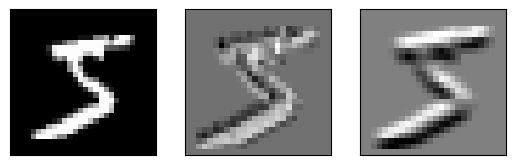

In [36]:
with torch.autograd.no_grad():
    show_images((mnist_images[0].cpu(), 
                 conv2d(mnist_images[0][None, :])[0].cpu(), 
                 target_transformed_images[0].cpu()))
    
    # original image, image using the kernel, and what we want? I think

Now let's set some hyperparameters,

In [37]:
LEARNING_RATE = 0.001
N_EPOCHS = 50
BATCH_SIZE = 128

and make a `DataLoader` out of the original images and the desired processed images.

In [38]:
dataloader = data.DataLoader(data.TensorDataset(mnist_images, target_transformed_images),
                             batch_size=BATCH_SIZE, 
                             shuffle=True)

PyTorch has many `Optimizer`s, which take care of updating parameters and remembering updates to allow more sophisticated update schedules. We'll use `optim.SGD`. 

In [39]:
optimizer = torch.optim.SGD(conv2d.parameters(), lr=LEARNING_RATE)

Now for the training loop. Upon loading each batch, 
1. The optimizer zeros all the gradients.
1. The $\hat{f}$ performs cross-correlation on the batch of images using the current kernel.
1. The loss function calculates a scalar loss value.
1. We call `backward` on the loss value, which adds the gradient of the loss with respect to each parameter to the gradients.
1. We call `step` on the `Optimizer`, which updates the parameters using the gradients and the learning rate.

In [40]:
def train():
    for epoch_number in (progress_bar := tqdm.tqdm(range(N_EPOCHS), desc=f"training")):
        epoch_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            z = conv2d(x.to(device))
            loss = criterion(z, y.to(device))
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        progress_bar.set_postfix_str(f"loss: {epoch_loss}")

In [41]:
train()

training: 100%|██████████| 50/50 [00:53<00:00,  1.08s/it, loss: 0.6230588358594105]


So, we've trained for a while. Guess what the kernel is.

In [42]:
conv2d.weight[0][0]

tensor([[-1.0581, -1.0663, -0.8462],
        [ 0.1302, -0.0241, -0.1092],
        [ 0.8233,  1.2331,  0.8926]], grad_fn=<SelectBackward0>)

Probably not very close to the reference kernel. But let's take a look at a cross-correlation using this kernel.

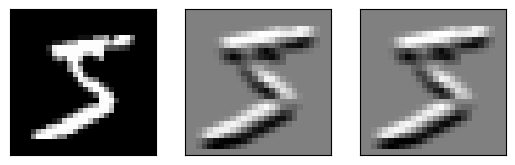

In [43]:
with torch.autograd.no_grad():
    show_images((mnist_images[0].cpu(), 
                 conv2d(mnist_images[0][None, :])[0].cpu(), 
                 target_transformed_images[0].cpu()))

In my case, even though the kernel wasn't close, the effect of using it was pretty close.

Worth discussing with your friends:
> Why was the learned kernel not close to the reference kernel used to generate the target data, while the effect of using it was similar.

A hint:

In [ ]:
# print(base64.b64decode(b'Y29udjJkLndlaWdodFswXVswXS5tZWFuKDEp').decode())